In [10]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
sys.path.insert(0,'..')
from nrel_xstock.database import SQLiteDatabase, ResstockDatabase
from nrel_xstock.__main__ import CityLearnSimulator
from nrel_xstock.simulate import OpenStudioModelEditor
from nrel_xstock.utilities import write_data, get_data_from_path, write_json

In [2]:
database_filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/data/nrel/database.db'
database = ResstockDatabase(filepath=database_filepath)

# EnergyPlus Simulation
***

In [21]:
database.query_table("select * from citylearn_energyplus_simulation_result limit 10")

,metadata_id,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature (C),Average Unmet Cooling Setpoint Difference (C),Average Unmet Heating Setpoint Difference (C),Indoor Relative Humidity (%),Equipment Electric Power (kWh),DHW Heating (kWh),Cooling Load (kWh),Heating Load (kWh)
0,1,1,1,1,0,23.097187,0.791702,2.541632,42.653776,0.346120,1.31882,0.0,0.000000
1,1,1,2,1,0,22.832708,1.056181,2.277153,43.474914,0.254371,1.31882,0.0,0.000000
2,1,1,3,1,0,22.628865,1.260024,2.073310,44.160555,0.188268,1.31882,0.0,0.000000
3,1,1,4,1,0,22.388638,1.500251,1.833082,44.950541,0.186285,1.31882,0.0,0.000000
4,1,1,5,1,0,22.122498,1.766391,1.566942,45.817445,0.216485,1.31882,0.0,0.000000
5,1,1,6,1,0,21.976549,1.912339,1.420994,46.362451,0.406632,1.31882,0.0,0.000000
6,1,1,7,1,0,21.874131,2.014758,1.318575,46.839768,0.856095,1.31882,0.0,0.000000
7,1,1,8,1,0,23.857101,0.031788,0.031788,41.652311,1.146738,1.31882,0.0,9.840059
8,1,1,9,1,0,23.888892,0.000003,0.000003,41.744187,1.255500,1.31882,0.0,6.961522
9,1,1,10,1,0,23.888891,0.000002,0.000002,41.893924,1.263590,1.31882,0.0,5.074873


In [4]:
def citylearn_simulator(metadata_id='135',root_output_directory=None):
    idd_filepath = '/Applications/EnergyPlus-9-6-0/PreProcess/IDFVersionUpdater/V9-6-0-Energy+.idd'
    simulation_result_query_filepath = 'misc/citylearn_simulation_result.sql'

    # get input data for simulation
    sim_data = database.query_table(
        f"SELECT osm, epw FROM building_energy_performance_simulation_input WHERE metadata_id = {metadata_id}"
    )
    osm, epw = sim_data.to_records(index=False)[0]
    schedules_filepath = 'schedules.csv'
    schedule = database.query_table(f"SELECT * FROM schedule WHERE metadata_id = {metadata_id}")
    schedule = schedule.drop(columns=['metadata_id','day','hour','minute',])
    schedule.to_csv(schedules_filepath,index=False)
    output_directory = f'{metadata_id}_simulation'
    output_directory = os.path.join(root_output_directory,output_directory) if root_output_directory is not None else output_directory
    
    # preprocess osm as needed and translate to idf
    osm_editor = OpenStudioModelEditor(osm)
    osm_editor.use_ideal_loads_air_system()
    idf = osm_editor.forward_translate()
    simulator = CityLearnSimulator(idd_filepath,idf,epw,simulation_id=metadata_id,output_directory=output_directory)
    simulator.preprocess()

    # simulate
    simulator.simulate()
    os.remove(schedules_filepath)
    simulation_result = simulator.get_simulation_result(simulation_result_query_filepath)
    return simulation_result

metadata_ids = database.query_table(f"SELECT id FROM metadata")['id'].astype(str).tolist()
root_output_directory = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/data/nrel/energyplus_simulation'

for i, metadata_id in enumerate(metadata_ids):
    idf = simulation_result = citylearn_simulator(metadata_id,root_output_directory=root_output_directory)
    assert False
    simulation_result.columns = [c.replace('[','(').replace(']',')') for c in simulation_result.columns]
    simulation_result['metadata_id'] = metadata_id
    database.insert(
        'citylearn_energyplus_simulation_result',
        simulation_result.columns.tolist(),
        simulation_result.values,
        on_conflict_fields=['metadata_id','Month','Hour', 'Day Type']
    )

print()

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


EnergyPlusRunError: 

Contents of EnergyPlus error file at /Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/data/nrel/energyplus_simulation/1_simulation/eplusout.err
<File not found>

Program terminated: EnergyPlus Terminated--Error(s) Detected.


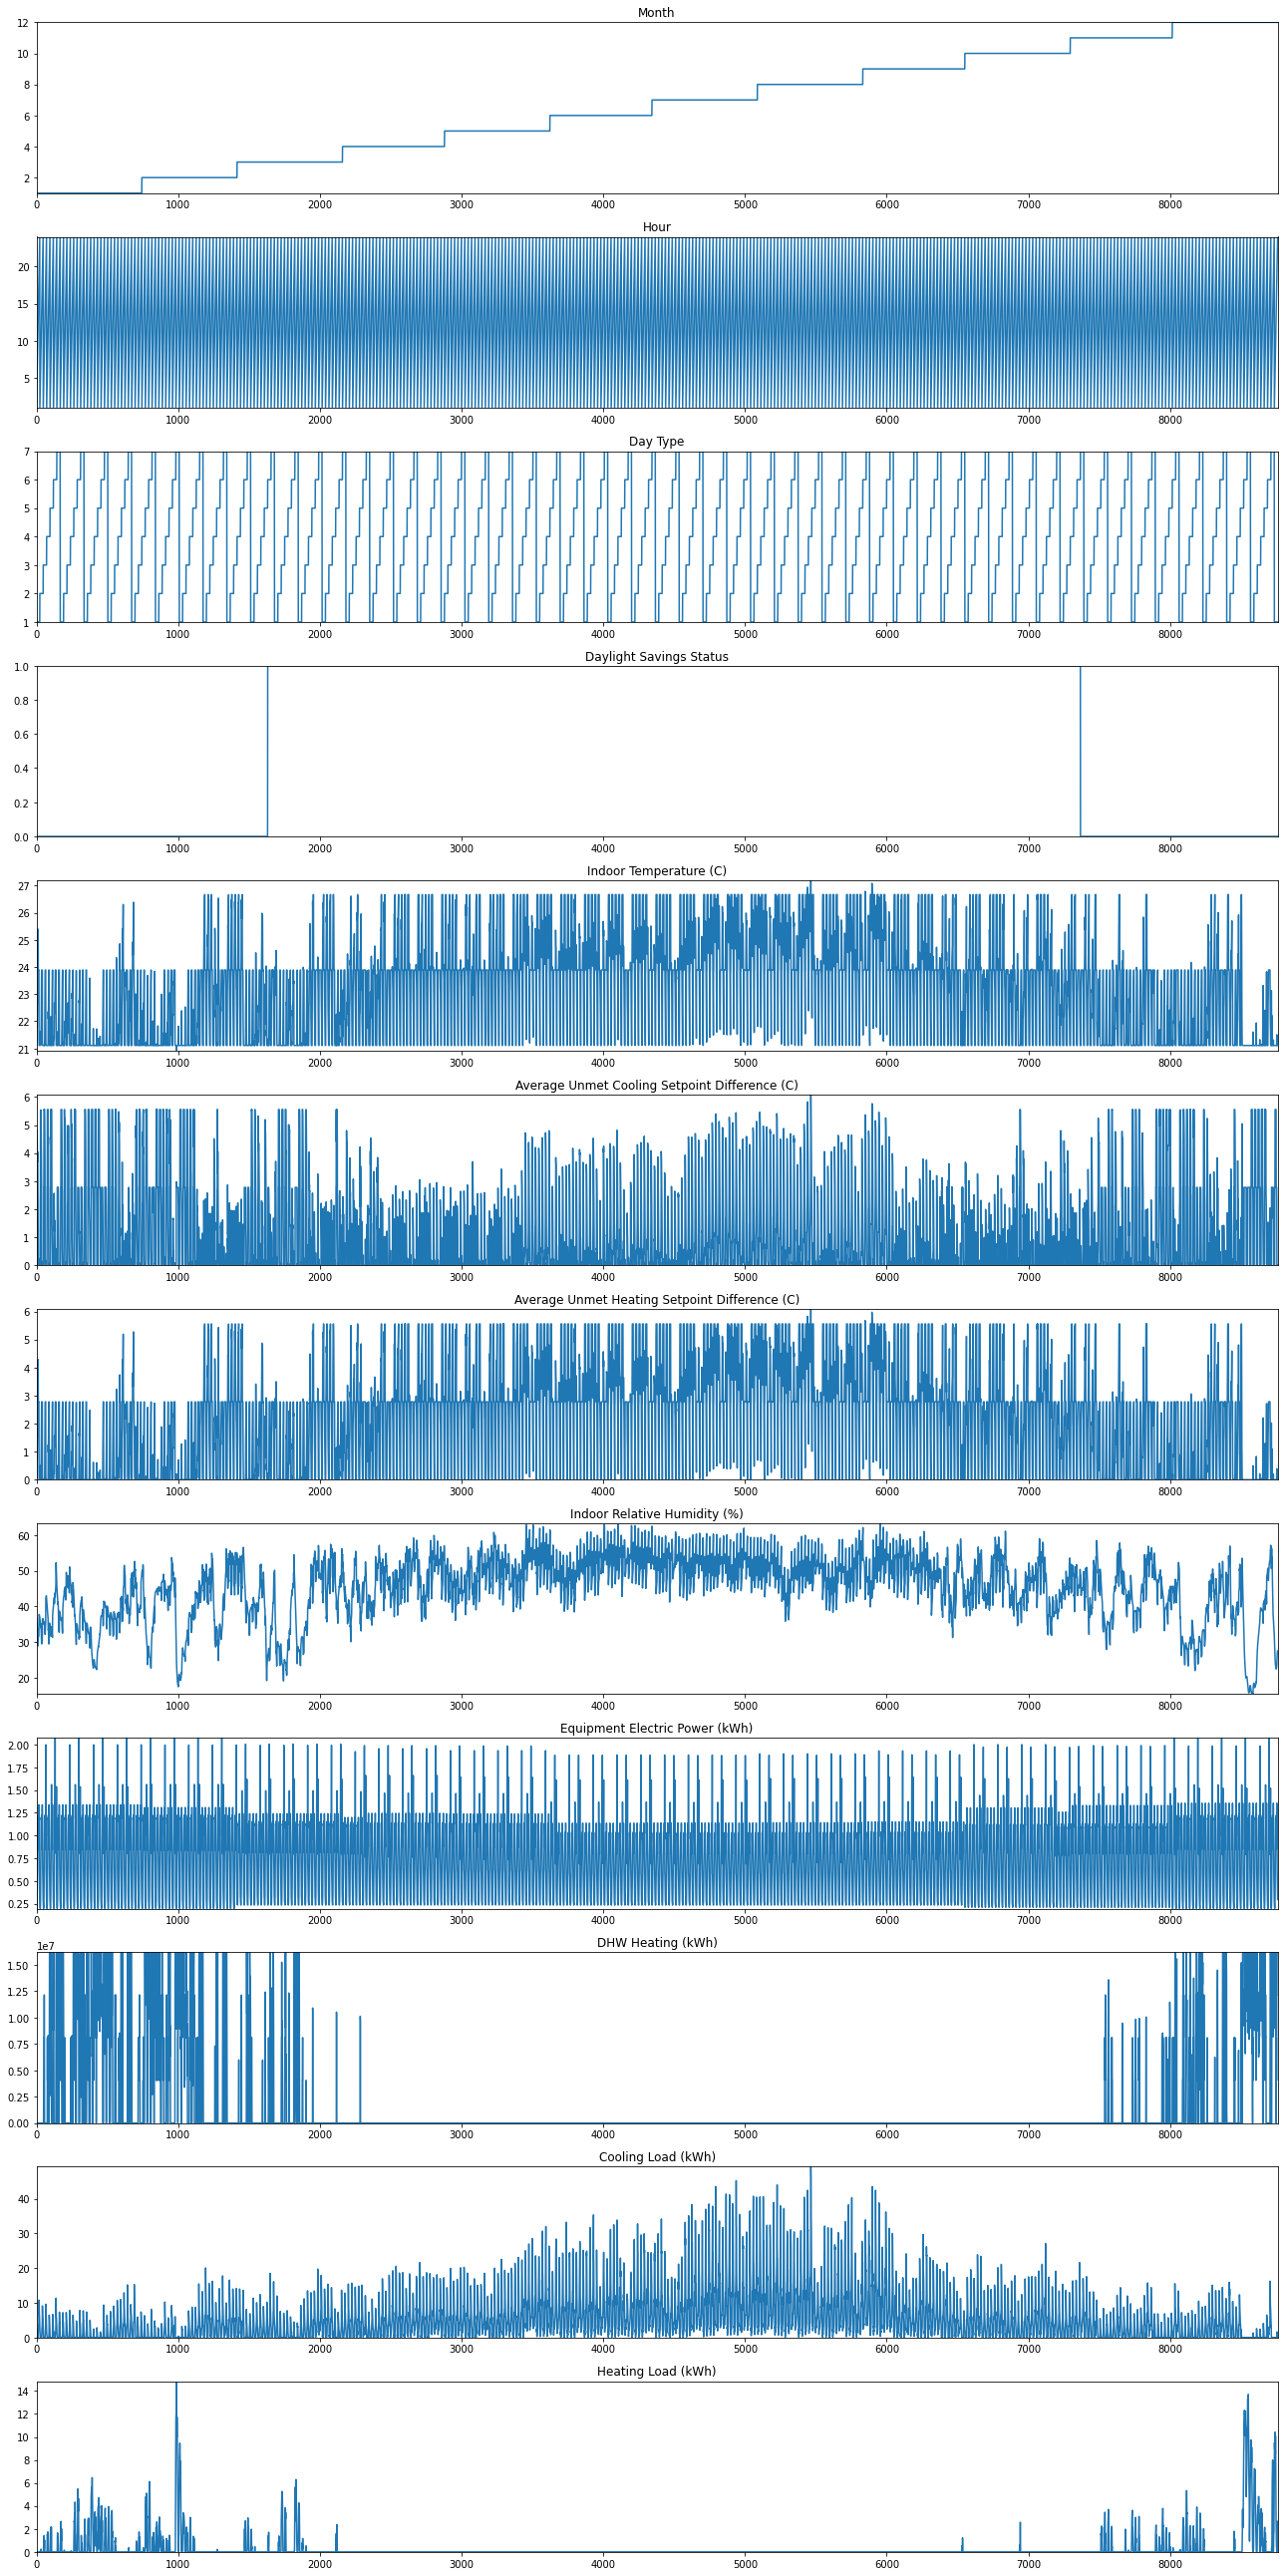

In [16]:
filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/data/nrel/energyplus_simulation/135_simulation/135.sql'

with open('misc/citylearn_simulation_result.sql','r') as f:
    query = f.read()

output = SQLiteDatabase(filepath)
data = output.query_table(query)
fig, axs = plt.subplots(data.shape[1],1,figsize=(18,data.shape[1]*3))

for ax, column in zip(fig.axes,data.columns):
    ax.plot(data[column])
    ax.set_title(column)
    ax.margins(0)

plt.tight_layout()
plt.show()
# data['mode'] = 'heat'
# data.loc[data['Value'] < 0, 'mode'] = 'cool'
# data['Value'] = data['Value'].abs()
# data = data.pivot(index='TimeIndex',columns='mode',values='Value')
# data = data.fillna(0)
# data.plot(figsize=(20,4))

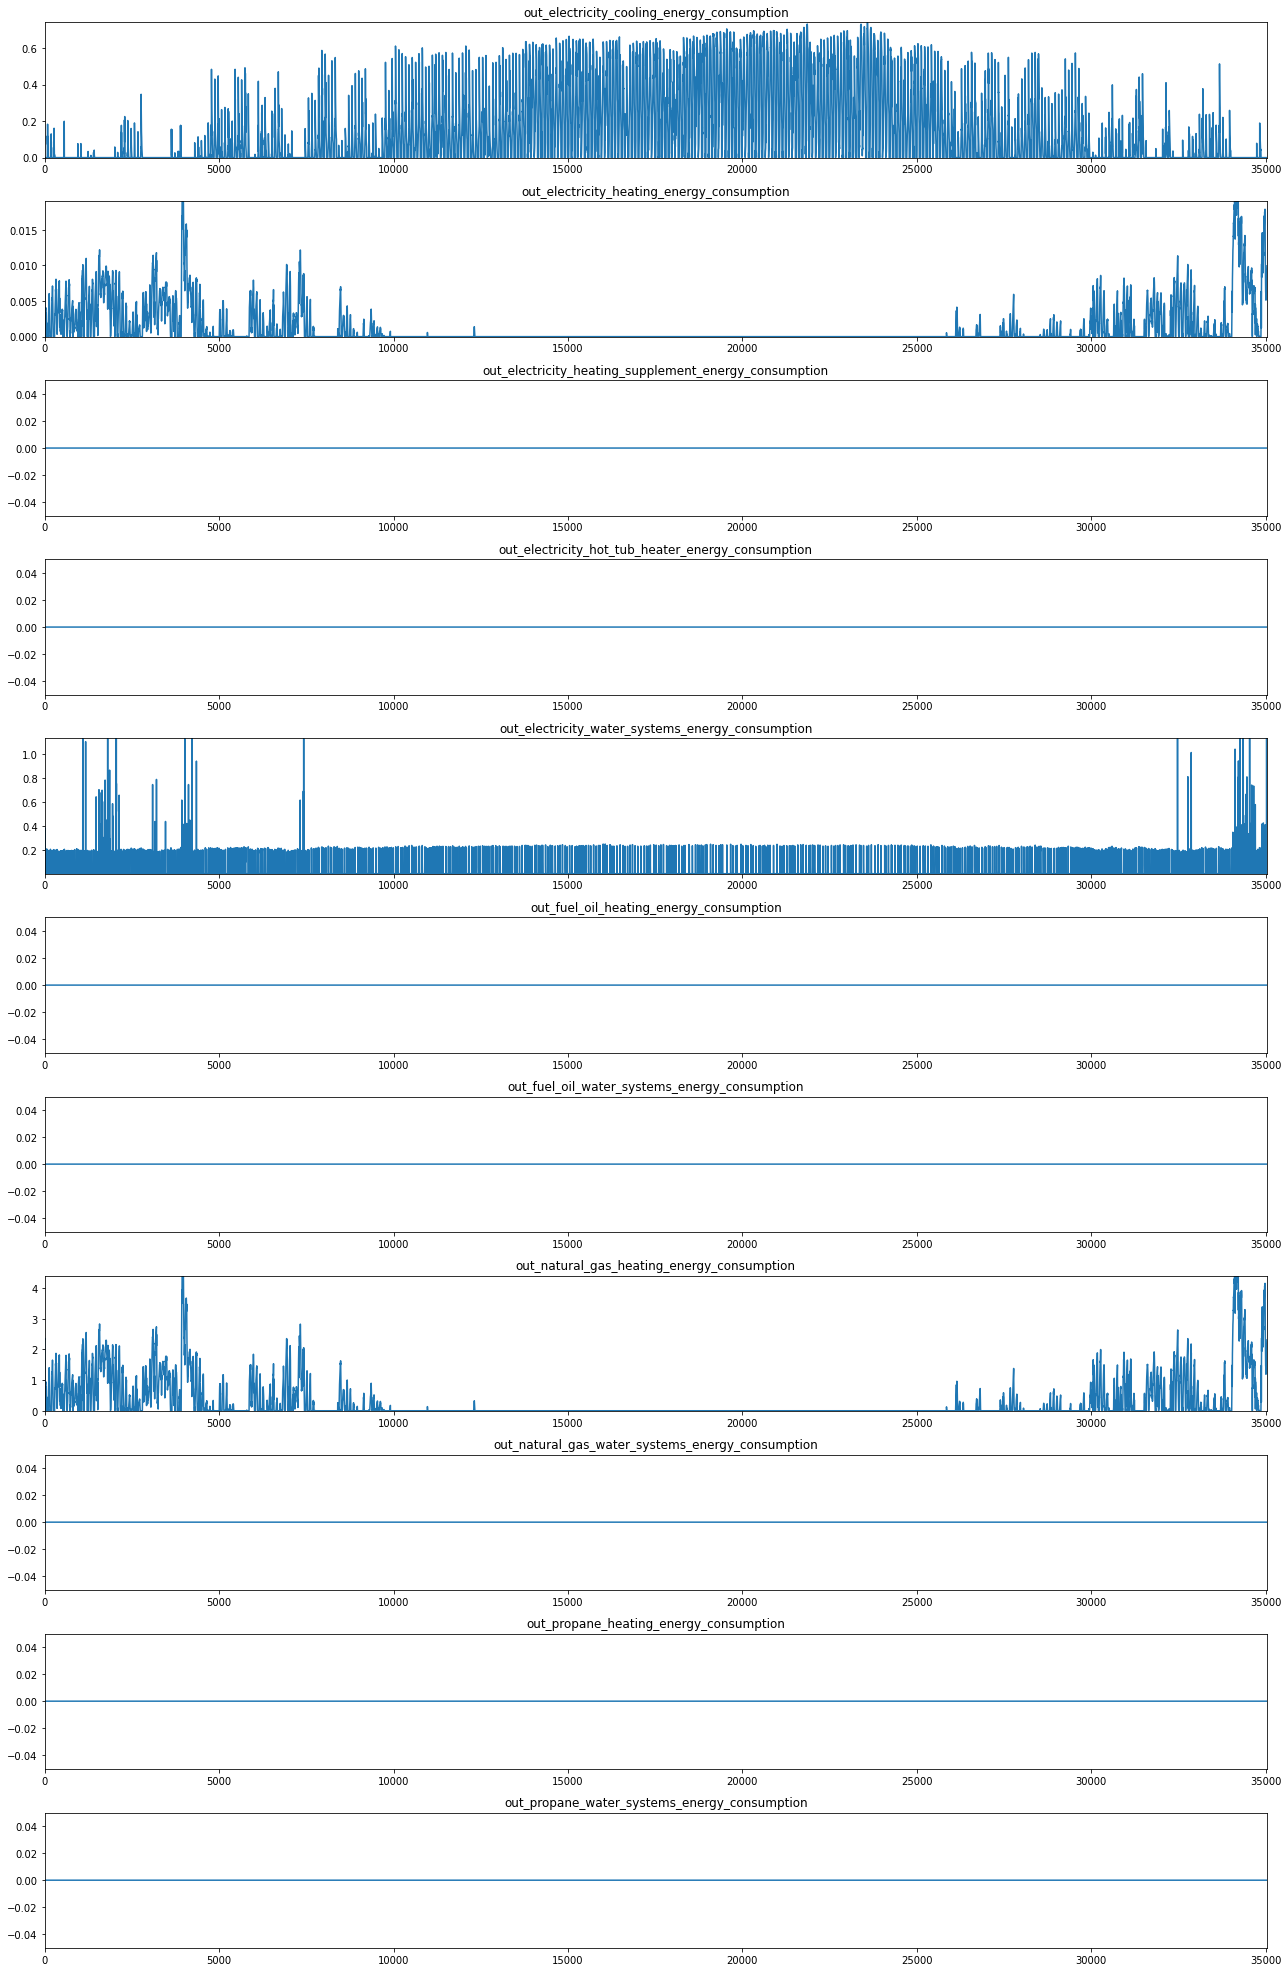

In [9]:
query = """
SELECT
out_electricity_cooling_energy_consumption,
out_electricity_heating_energy_consumption,
out_electricity_heating_supplement_energy_consumption,
out_electricity_hot_tub_heater_energy_consumption,
out_electricity_water_systems_energy_consumption,
out_fuel_oil_heating_energy_consumption,
out_fuel_oil_water_systems_energy_consumption,
out_natural_gas_heating_energy_consumption,
out_natural_gas_water_systems_energy_consumption,
out_propane_heating_energy_consumption,
out_propane_water_systems_energy_consumption
FROM timeseries WHERE metadata_id = 135
"""
data = database.query_table(query)
fig, axs = plt.subplots(data.shape[1],1,figsize=(18,data.shape[1]*2.5))

for ax, column in zip(fig.axes,data.columns):
    ax.plot(data[column])
    ax.set_title(column)
    ax.margins(0)

plt.tight_layout()
plt.show()

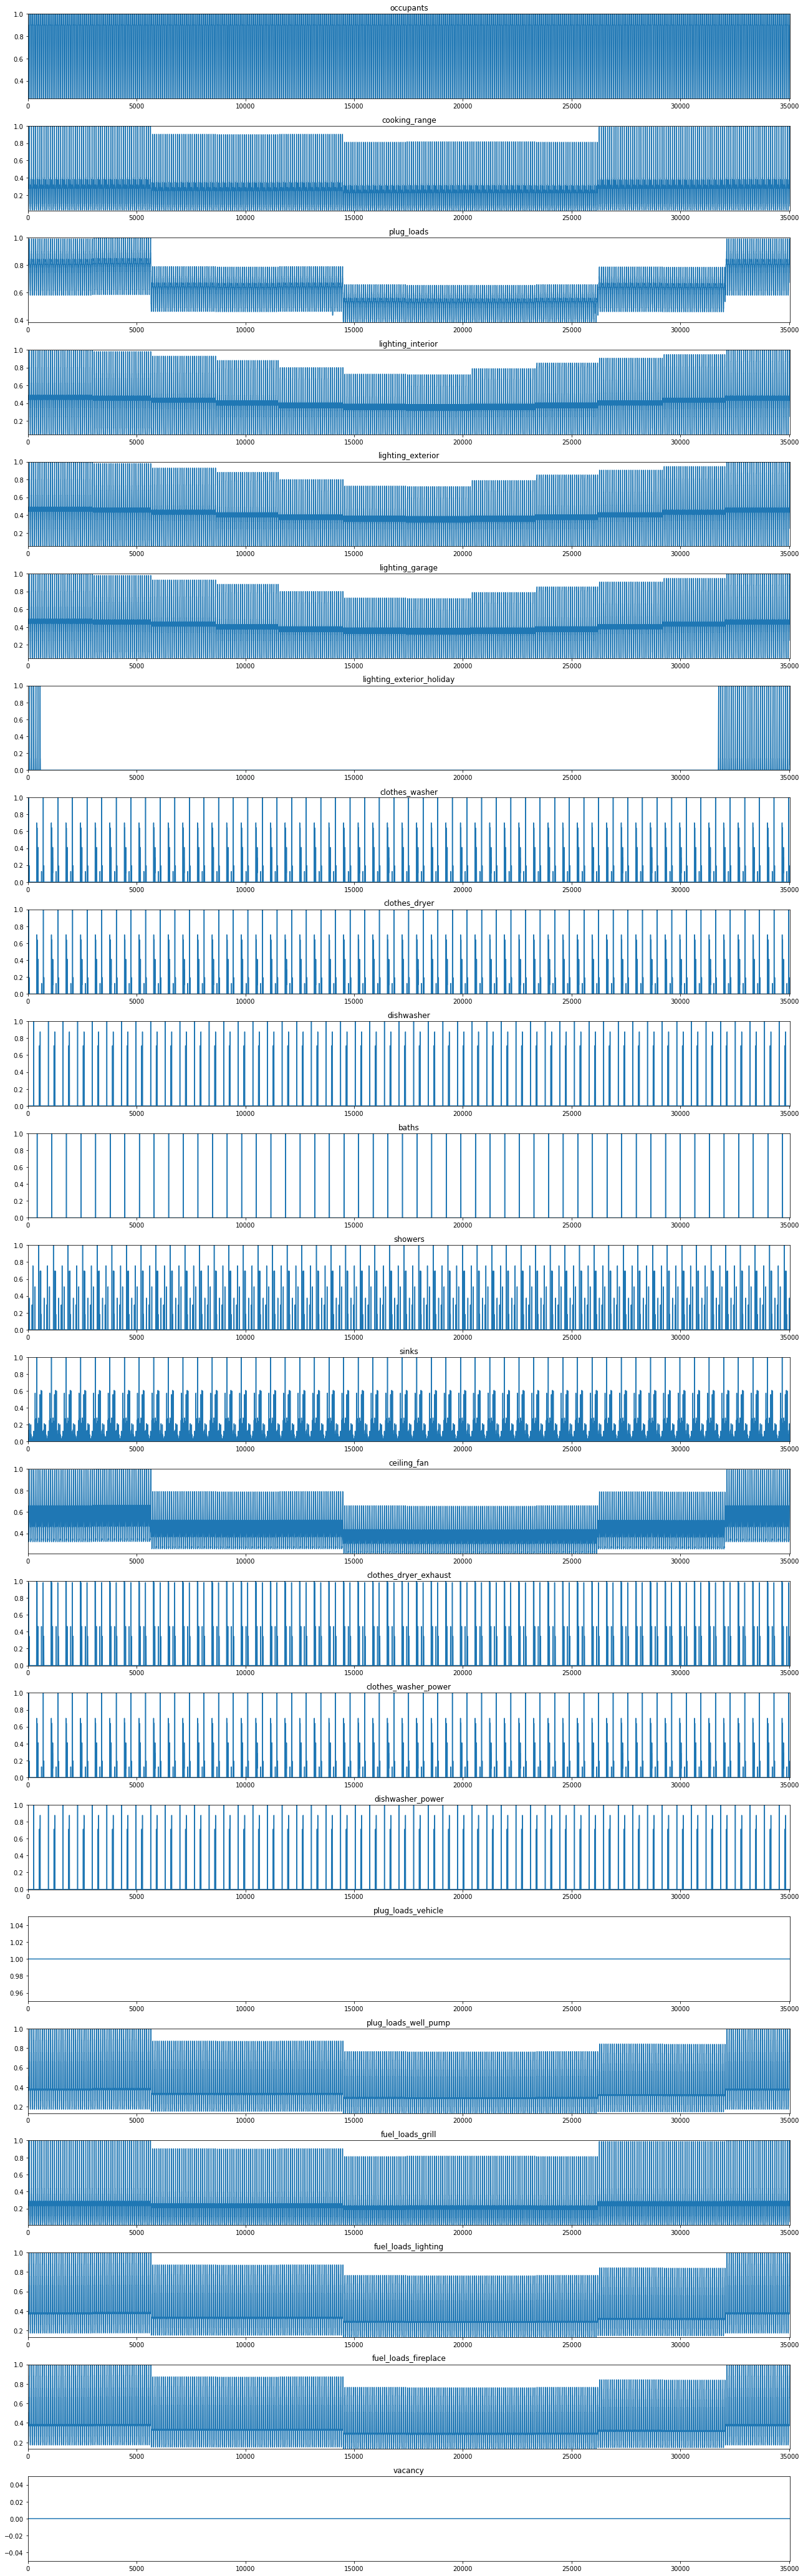

In [11]:
data = pd.read_csv('schedules.csv')
fig, axs = plt.subplots(data.shape[1],1,figsize=(18,data.shape[1]*2.5))

for ax, column in zip(fig.axes,data.columns):
    ax.plot(data[column])
    ax.set_title(column)
    ax.margins(0)

plt.tight_layout()
plt.show()

In [23]:
query = """
SELECT id, in_has_pv, in_pv_orientation, in_pv_system_size FROM metadata
"""
data = database.query_table(query)
data

,id,in_has_pv,in_pv_orientation,in_pv_system_size
0,1,No,None,None
1,2,No,None,None
2,3,No,None,None
3,4,No,None,None
4,5,No,None,None
5,6,No,None,None
6,7,No,None,None
7,8,No,None,None
8,9,No,None,None
9,10,No,None,None
